In [1]:
! git clone https://github.com/tlapinsk/colab-examples.git

Cloning into 'colab-examples'...
remote: Enumerating objects: 37407, done.
remote: Total 37407 (delta 0), reused 0 (delta 0), pack-reused 37407
Receiving objects: 100% (37407/37407), 810.11 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (37503/37503), done.


In [2]:
! ls

colab-examples	sample_data


In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("colab-examples/data"))

Using TensorFlow backend.


['test', 'train']


In [0]:
# Set some variables
FAST_RUN       = False
IMAGE_WIDTH    = 128
IMAGE_HEIGHT   = 128
IMAGE_SIZE     = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [5]:
# Split into dog versus cat categories (0, 1)
filenames = os.listdir("colab-examples/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Preview changes
df.head()

,filename,category
0,cat.11294.jpg,0
1,cat.11657.jpg,0
2,dog.8074.jpg,1
3,cat.8870.jpg,0
4,dog.12030.jpg,1


In [6]:
# Preview changes
df.tail()

,filename,category
24995,cat.336.jpg,0
24996,cat.8868.jpg,0
24997,dog.12452.jpg,1
24998,dog.605.jpg,1
24999,dog.10763.jpg,1


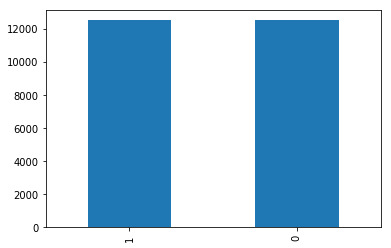

In [7]:
# Check out totals in a bar graph
df['category'].value_counts().plot.bar()

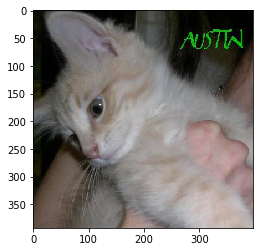

In [8]:
# Random sample image
sample = random.choice(filenames)
image = load_img("colab-examples/data/train/"+sample)
plt.imshow(image)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Build Keras model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# View summary of model
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256     

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

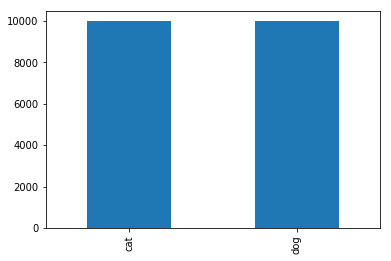

In [11]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

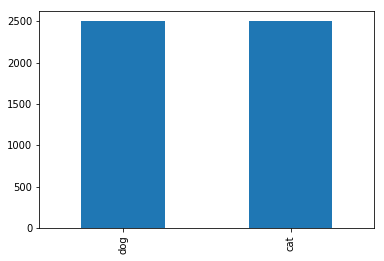

In [12]:
validate_df['category'].value_counts().plot.bar()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [14]:
# Build training generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "colab-examples/data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
# Build validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "colab-examples/data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "colab-examples/data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


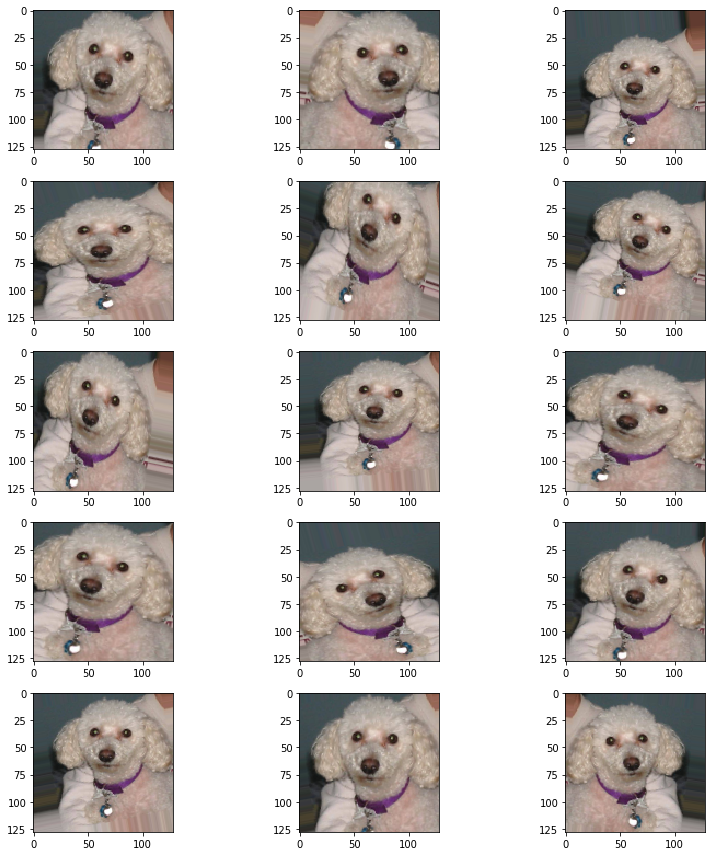

In [17]:
# Sample generator image
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1333/1333 [==============================] - 181s 136ms/step - loss: 0.7538 - acc: 0.6330 - val_loss: 0.5875 - val_acc: 0.7073
Epoch 2/50
1333/1333 [==============================] - 176s 132ms/step - loss: 0.5644 - acc: 0.7136 - val_loss: 0.5068 - val_acc: 0.7575
Epoch 3/50
1333/1333 [==============================] - 176s 132ms/step - loss: 0.5064 - acc: 0.7619 - val_loss: 0.4760 - val_acc: 0.7745
Epoch 4/50
1333/1333 [==============================] - 176s 132ms/step - loss: 0.4652 - acc: 0.7875 - val_loss: 0.6807 - val_acc: 0.7218
Epoch 5/50
1333/1333 [==============================] - 177s 133ms/step - loss: 0.4415 - acc: 0.8009 - val_loss: 0.3837 - val_acc: 0.8267
Epoch 6/50
1333/1333 [==============================] - 175s 132ms/step - loss: 0.4216 - acc: 0.8101 - val_loss: 0.3971 - val_acc: 0.8325
Epoch 7/50
1333/1333 [==============================] - 175s 131ms/step - loss

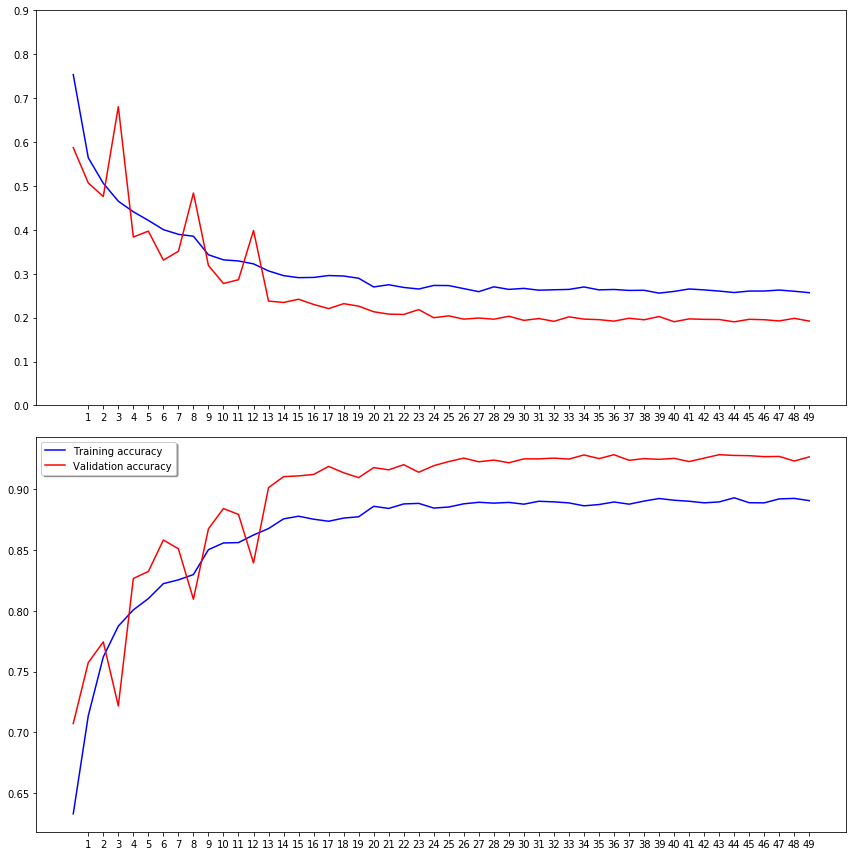

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()